# Download

This section assumes [Kaggle is configured](https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md#api-credentials).


In [1]:
!pwd

/workspaces/isic/nbs


In [2]:
%env KAGGLE_COMPETITION=isic-2024-challenge
%env DATA_DIR=../data

env: KAGGLE_COMPETITION=isic-2024-challenge
env: DATA_DIR=../data


In [3]:
!kaggle config view

Configuration values from /home/vscode/.kaggle
- username: joshwiley
- path: None
- proxy: None
- competition: None


In [4]:
!kaggle competitions download --path $DATA_DIR $KAGGLE_COMPETITION 

 95%|████████████████████████████████████  | 1.90G/2.00G [00:01<00:00, 1.10GB/s]
100%|██████████████████████████████████████| 2.00G/2.00G [00:01<00:00, 1.12GB/s]


In [5]:
!unzip -d $DATA_DIR $DATA_DIR/$KAGGLE_COMPETITION.zip -x train-image/* > /dev/null

In [6]:
!rm $DATA_DIR/$KAGGLE_COMPETITION.zip

In [7]:
!ls $DATA_DIR

sample_submission.csv  test-metadata.csv  train-metadata.csv
test-image.hdf5        train-image.hdf5


# Convert


In [8]:
from pathlib import Path
import os

DATA_DIR = Path(os.getenv("DATA_DIR")).resolve()

DATA_DIR

PosixPath('/workspaces/isic/data')

In [9]:
TRAIN_IMAGES_FILE = DATA_DIR / "train-image.hdf5"
TRAIN_METADATA_FILE = DATA_DIR / "train-metadata.csv"
TEST_IMAGES_FILE = DATA_DIR / "test-image.hdf5"
TEST_METADATA_FILE = DATA_DIR / "test-metadata.csv"

TRAIN_IMAGES_FILE, TRAIN_METADATA_FILE, TEST_IMAGES_FILE, TEST_METADATA_FILE

(PosixPath('/workspaces/isic/data/train-image.hdf5'),
 PosixPath('/workspaces/isic/data/train-metadata.csv'),
 PosixPath('/workspaces/isic/data/test-image.hdf5'),
 PosixPath('/workspaces/isic/data/test-metadata.csv'))

In [10]:
from pyarrow import csv

train_df = csv.read_csv(TRAIN_METADATA_FILE).to_pandas()
test_df = csv.read_csv(TEST_METADATA_FILE).to_pandas()

(len(train_df), len(test_df))

(401059, 3)

In [11]:
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

print("Columns missing in test split:")
print(train_cols - test_cols)

Columns missing in test split:
{'iddx_1', 'mel_thick_mm', 'lesion_id', 'mel_mitotic_index', 'iddx_4', 'iddx_5', 'iddx_full', 'iddx_2', 'tbp_lv_dnn_lesion_confidence', 'target', 'iddx_3'}


The available test split contains only contains 3 rows. Since the real test split is not pulicly available, the public test split will be ignored.


In [12]:
train_df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,,Benign,Benign,,,,,,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,,,,,,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,,Benign,Benign,,,,,,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,,Benign,Benign,,,,,,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,,Benign,Benign,,,,,,NaN,70.442510


ISIC_0015670


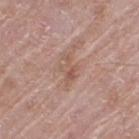

ISIC_0015845


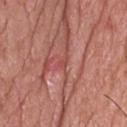

ISIC_0015864


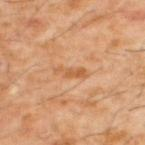

In [13]:
import io

import h5py
from PIL import Image
from PIL.Image import Image as PILImage


def get_image(file: h5py.File, key: str) -> PILImage:
    b = io.BytesIO(file[key][()])
    return Image.open(b)


with h5py.File(TRAIN_IMAGES_FILE, "r") as f:
    for isic_id in train_df["isic_id"][:3]:
        print(isic_id)
        image = get_image(f, isic_id)
        display(image)

In [14]:
from functools import partial
from typing import TypedDict, Optional
from datasets import Image as HFImage

image_feature = HFImage()


class EncodedImage(TypedDict):
    path: Optional[str]
    bytes: Optional[bytes]


def encode_image(file: h5py.File, key: str) -> EncodedImage:
    image = get_image(file, key)
    return image_feature.encode_example(image)


with h5py.File(TRAIN_IMAGES_FILE, "r") as f:
    encode_train_image = partial(encode_image, f)
    train_df["image"] = train_df["isic_id"].apply(encode_train_image)

train_df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,image
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,,,,,,NaN,97.517282,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,,,,,,NaN,3.141455,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,,,,,,NaN,99.804040,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,,,,,,NaN,99.989998,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,,,,,,NaN,70.442510,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."


In [15]:
from datasets import Dataset, DatasetDict, Image as HFImage

train_dataset = Dataset.from_pandas(train_df)
train_dataset.cast_column("image", HFImage())

dataset = DatasetDict({"train": train_dataset})

dataset

DatasetDict({
    train: Dataset({
        features: ['isic_id', 'target', 'patient_id', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence', 'ima

# Upload


In [16]:
from huggingface_hub import whoami

whoami()

{'type': 'user',
 'id': '633ae6e89f5846dc43009bc7',
 'name': 'mrbrobot',
 'fullname': 'Josh Wiley',
 'isPro': False,
 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/633ae6e89f5846dc43009bc7/-amzcpjqsmLsukZvjrH8j.jpeg',
 'orgs': [{'type': 'org',
   'id': '633ae878437225ed953a6ced',
   'name': 'cloudbend',
   'fullname': 'Cloudbend',
   'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/1664804970663-633ae6e89f5846dc43009bc7.png',
   'isEnterprise': False}],
 'auth': {'type': 'access_token',
  'accessToken': {'displayName': 'hercules_repo_write',
   'role': 'fineGrained',
   'createdAt': '2025-10-13T15:22:55.485Z',
   'fineGrained': {'canReadGatedRepos': False,
    'global': [],
    'scoped': [{'entity': {'_id': '633ae6e89f5846dc43009bc7',
       'type': 'user',
       'name': 'mrbrobot'},
      'permissions': ['repo.content.read', 'repo.write']}]}}}}

In [17]:
username = whoami()["name"]

dataset.push_to_hub(
    f"{username}/isic-2024",
    private=False,
    commit_message="ISIC 2024 - Skin Cancer Detection with 3D-TBP",
)

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/mrbrobot/isic-2024/commit/bc36ecd20c1bb85ca09f8068b84ced843cd67433', commit_message='ISIC 2024 - Skin Cancer Detection with 3D-TBP', commit_description='', oid='bc36ecd20c1bb85ca09f8068b84ced843cd67433', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mrbrobot/isic-2024', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mrbrobot/isic-2024'), pr_revision=None, pr_num=None)

# Cleanup


In [18]:
!rm -rf $DATA_DIR